# GMM + Bayesian Parameter Estimation + Grid search

## Imports

In [1]:
from functools import partial
import numpy as np
from numpy.random import normal
from scipy.stats import norm
import matplotlib.pyplot as plt
from seaborn import kdeplot as kde

/Users/yangzhihan/anaconda/envs/deeplearning_googlecloud/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/yangzhihan/anaconda/envs/deeplearning_googlecloud/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [200]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Create datasets

In [124]:
dist_1 = partial(normal, loc=4, scale=1)
dist_2 = partial(normal, loc=8, scale=1)

In [149]:
def true_density(size):
    mcoeffs = np.random.choice([0, 1], size=size, p=[1/3, 2/3])
    dist_1_sample = dist_1(size=size) * mcoeffs  # 2/3
    dist_1_sample = dist_1_sample[dist_1_sample > 0]
    dist_2_sample = dist_2(size=size) * np.logical_not(mcoeffs)
    dist_2_sample = dist_2_sample[dist_2_sample > 0]
    sample = np.concatenate([dist_1_sample, dist_2_sample])
    np.random.shuffle(sample)
    return sample

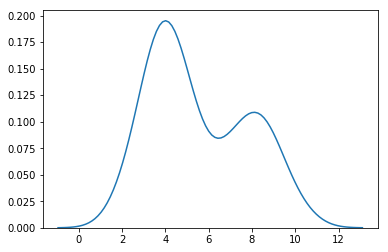

In [171]:
data = true_density(100)
kde(data); plt.show()

## Define priors

In [677]:
prior_mcoeff = norm(loc=1, scale=0.5)
prior_mu1 = norm(loc=7, scale=2)
prior_mu2 = norm(loc=7, scale=2)

In [678]:
def prior(thetas):
    probas = []
    for i in range(thetas.shape[0]):
        mcoeff, mu1, mu2 = thetas[i]
        proba = prior_mcoeff.pdf(mcoeff) * prior_mu1.pdf(mu1) * prior_mu2.pdf(mu2)
        probas.append(proba)
    probas = np.array(probas)
    return probas

## Define update rule

In [679]:
STEPSIZE = 0.1 * 1 * 1

In [680]:
def normalize(densities):
    return densities / densities.max()

In [681]:
def likelihood(data, thetas):
    
    likelihoods = []
    for i in log_progress(list(range(thetas.shape[0])), every=10):
    
        mcoeff, mu1, mu2 = thetas[i]
        model_1, model_2 = norm(loc=mu1, scale=1), norm(loc=mu2, scale=1)

        likelihood_model_1 = model_1.pdf(data)
        likelihood_model_2 = model_2.pdf(data)

        likelihood = np.prod(mcoeff * likelihood_model_1 + (1 - mcoeff) * likelihood_model_2)
        likelihoods.append(likelihood)
        
    likelihoods = np.array(likelihoods)
    return likelihoods

In [682]:
def posterior(prior, thetas, data):
    priors = prior(thetas)
    likelihoods = likelihood(data, thetas)
    unnormalized_posteriors = prior(thetas) * likelihoods
    return priors, likelihoods, normalize(unnormalized_posteriors)

## Training

Set up grid search:

In [683]:
mcoeffs = np.arange(0, 1, 0.1)
mu1s = np.arange(0, 14, 1)  # does not make sense for stepsize to be greater than 1
mu2s = np.arange(0, 14, 1)
mcoeffs_grid, mu1s_grid, mu2s_grid = np.array(np.meshgrid(mcoeffs, mu1s, mu2s))
print(mcoeffs_grid.shape, mu1s_grid.shape, mu2s_grid.shape)

(14, 10, 14) (14, 10, 14) (14, 10, 14)


In [684]:
thetas = np.vstack([mcoeffs_grid.flatten(), mu1s_grid.flatten(), mu2s_grid.flatten()]).T
print(thetas.shape)

(1960, 3)


Training:

In [697]:
num_examples = 10  # too big leads to underflow

In [698]:
gen = true_density(size=num_examples)
priors, likelihoods, posteriors = posterior(prior, thetas, gen)

In [699]:
grid_shape = (len(mu1s), len(mcoeffs), len(mu2s))
priors = priors.reshape(grid_shape)
likelihoods = likelihoods.reshape(grid_shape)
posteriors = posteriors.reshape(grid_shape)

priors_section = priors[:,0,:]
likelihoods_section = likelihoods[:,4,:]
posteriors_section = posteriors[:,4,:]

Find axis of non-repetition:

In [700]:
print(mcoeffs_grid[0, :, 0])
print(mu1s_grid[:, 0, 0])
print(mu2s_grid[0, 0, :])

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


ML and MAP solutions:

In [701]:
def argmax_nd(array):
    return np.unravel_index(array.argmax(), array.shape)

In [713]:
ML = argmax_nd(likelihoods)
print(ML)  # second value can be both 3 and 7

(7, 3, 4)


In [714]:
MAP = argmax_nd(posteriors)
print(MAP)

(4, 7, 7)


Plot prior, likelihood and posterior distributions over means:

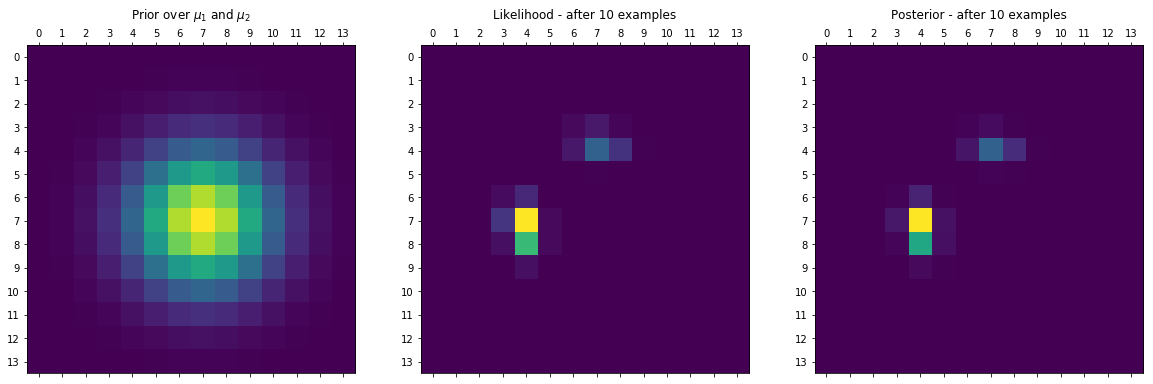

In [718]:
fig = plt.figure(figsize=(20, 7))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.matshow(priors_section)
ax2.matshow(likelihoods_section)
ax3.matshow(posteriors_section)

ax1.set_title(r'Prior over $\mu_1$ and $\mu_2$', pad=10)
ax2.set_title(f'Likelihood - after {num_examples} examples', pad=10)
ax3.set_title(f'Posterior - after {num_examples} examples', pad=10)

for ax in [ax1, ax2, ax3]:
    ax.set_xticks(np.arange(0, len(mu1s), 1))
    ax.set_yticks(np.arange(0, len(mu2s), 1))

plt.show()

Plot prior, likelihood and posterior distributions over the mixing coefficient:

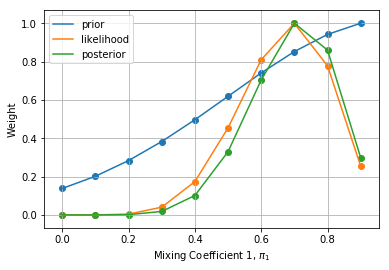

In [719]:
plt.plot(mcoeffs, priors[4,:,8] / priors[4,:,8].max(), label='prior')  
plt.scatter(mcoeffs, priors[4,:,8] / priors[4,:,8].max())

plt.plot(mcoeffs, likelihoods[4,:,8] / likelihoods[4,:,8].max(), label='likelihood')  
plt.scatter(mcoeffs, likelihoods[4,:,8] / likelihoods[4,:,8].max())

plt.plot(mcoeffs, posteriors[4,:,8] / posteriors[4,:,8].max(), label='posterior')
plt.scatter(mcoeffs, posteriors[4,:,8] / posteriors[4,:,8].max())
           
plt.xlabel(r'Mixing Coefficient 1, $\pi_1$'); plt.ylabel('Weight')
plt.grid(); plt.legend()
plt.show()